# Import lib & data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view

import io
from google.colab import files

from sklearn.preprocessing  import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

#!pip install scikit-optimize
from skopt import BayesSearchCV

from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

In [ ]:
uploaded = files.upload()

Saving Energy.csv to Energy.csv


In [ ]:
data = pd.read_csv('Energy.csv', index_col=0)

In [ ]:
data.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,11-01-2016 17:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.60,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,11-01-2016 17:10,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.48,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,11-01-2016 17:20,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.37,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,11-01-2016 17:30,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.25,733.8,92.0,6.000000,51.500000,5.0,45.410390,45.410390
4,11-01-2016 17:40,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.13,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


# Data partition

In [ ]:
energy = data.loc[:,'Appliances']

In [ ]:
e_train, e_test = energy.iloc[:12000], energy.iloc[12000:]

# Preprocessing

In [ ]:
# Normalize the data
w = 4
scaler = MinMaxScaler()
e_train_s = scaler.fit_transform(e_train.to_numpy().reshape(-1,1)) # to transf. from row vector tot column vector
e_test_s = scaler.transform(e_test.to_numpy().reshape(-1,1))

# Define windows
windows_train = sliding_window_view(e_train_s, w+1, axis=0).copy()
X_train_w, y_train_w = windows_train.squeeze()[:,:-1], windows_train.squeeze()[:,-1]

windows_test = sliding_window_view(e_test_s, w+1, axis=0).copy()
X_test_w, y_test_w = windows_test.squeeze()[:,:-1], windows_test.squeeze()[:,-1]

In [ ]:
X_train_w.shape, X_test_w.shape, y_train_w.shape, y_test_w.shape

((11996, 4), (7731, 4), (11996,), (7731,))

# kNN

* How many neighbors we use to make the prediction
* What distances use to recover them
* How we combine distances and what resolution of the index use to recover the * neighbors(kd-tree)

In [ ]:
knn = KNeighborsRegressor()

param = {'n_neighbors':[1,3,5,7,11,15,20,25], 'weights': ['distance', 'uniform'],
         'leaf_size': [1,5,10,15,20,25,30], 'metric': ['l2', 'l1', 'cosine']}

knn_search = BayesSearchCV(knn, param, n_iter = 15, cv=TimeSeriesSplit(n_splits=5, gap=+1),
                            scoring = make_scorer(mean_squared_error, greater_is_better=False), n_jobs=-1,
                            refit=True,random_state=0)
knn_search = knn_search.fit(X_train_w, y_train_w)

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [ ]:
show_html(pd.DataFrame(knn_search.cv_results_).loc[:,['params','mean_test_score','rank_test_score']].
          sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
4,"{'leaf_size': 5, 'metric': 'l2', 'n_neighbors': 15, 'weights': 'distance'}",-0.004092,1
7,"{'leaf_size': 15, 'metric': 'l1', 'n_neighbors': 15, 'weights': 'distance'}",-0.004120,2
9,"{'leaf_size': 10, 'metric': 'l1', 'n_neighbors': 5, 'weights': 'uniform'}",-0.004129,3
2,"{'leaf_size': 15, 'metric': 'l2', 'n_neighbors': 5, 'weights': 'distance'}",-0.004387,4
12,"{'leaf_size': 10, 'metric': 'l2', 'n_neighbors': 3, 'weights': 'uniform'}",-0.004628,5


## Performance evaluation

In [ ]:
mean_squared_error(y_test_w, knn_search.predict(X_test_w)), mean_absolute_error(y_test_w, knn_search.predict(X_test_w))

(0.003708675519232702, 0.027746296018152514)

## Predicted vs true values

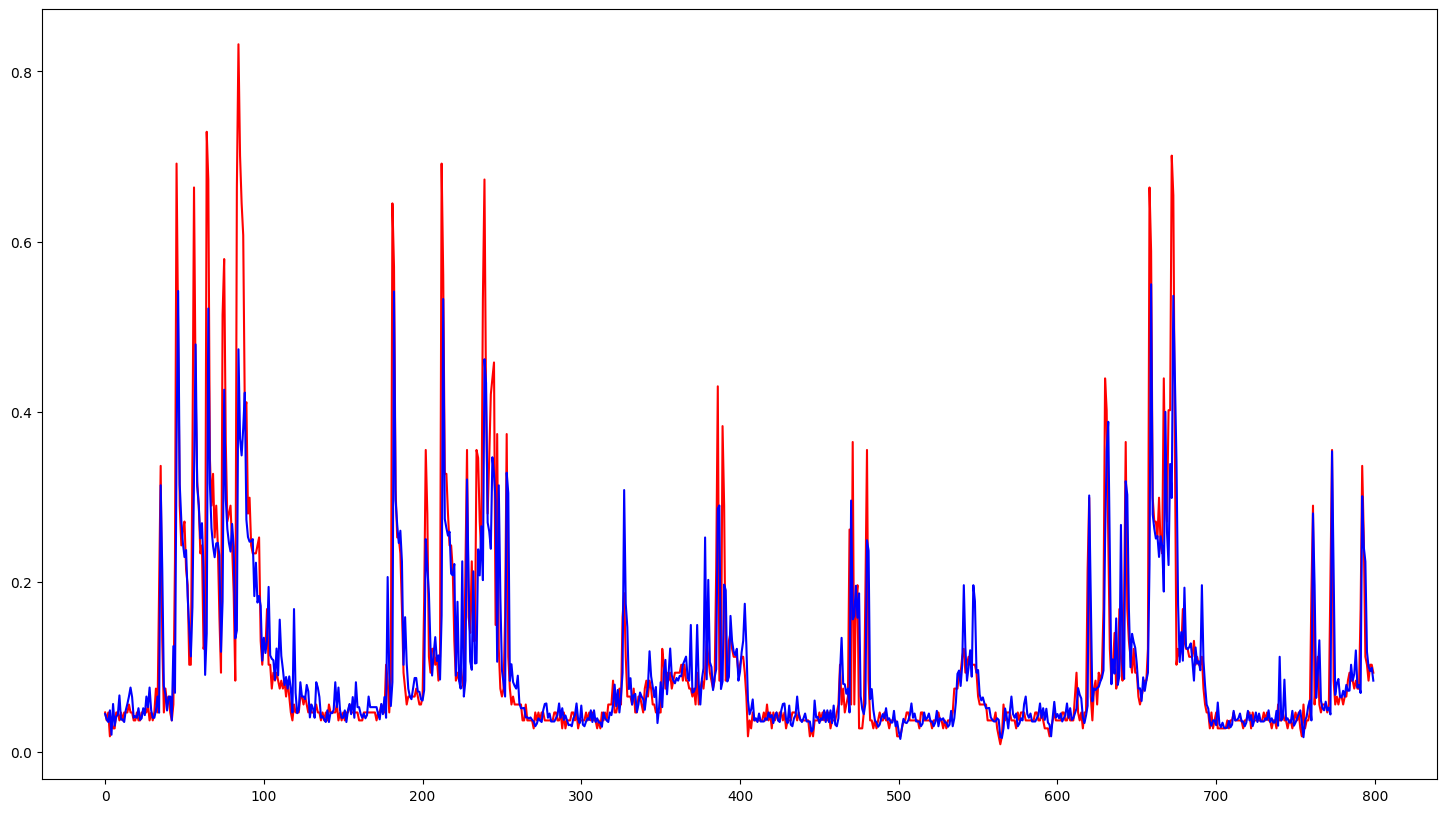

In [ ]:
plt.figure(figsize=(18,10))
plt.plot(y_test_w[:800], 'r')
plt.plot(knn_search.predict(X_test_w[:800]), 'b')